In [4]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", None)

In [5]:
ls data

 Volume in drive C is Windows
 Volume Serial Number is 6A32-22C4

 Directory of C:\Users\Shane\Downloads



File Not Found


In [ ]:
data_atlas = pd.read_csv('data/data_atlas.csv')
data_set = pd.read_csv('data/data_set.csv')
stock_history = pd.read_csv('data/stock_history.csv')
company_profile = pd.read_csv('data/company_profile.csv')
symbols = pd.read_csv('data/symbols.csv')

In [ ]:
data_atlas.Indicator.unique()

In [5]:
company_profile.groupby('SECTOR').apply(lambda x: x['INDUSTRY'].unique())

SECTOR
Basic Materials                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            [Building Materials, Metals & Mining, Steel, Other Industrial Metals & Mining, Copper, Gold, Independent Oil & Gas, Aluminum, Agricultural Inputs, Specialty Chemicals, Chemicals, Silver, Coking Coal, Lumber & Wood Production, Other Precious Metal

In [6]:
#Format datetime
stock_history['DATE'] =  pd.to_datetime(stock_history['DATE'])

In [7]:
# pd.read_csv('data/company_profile.csv')['INDUSTRY'].unique()
# pd.read_csv('data/company_profile.csv')['SECTOR'].unique()

In [8]:
def data_merger(symbol, 
                Country = 'United States of America', 
                Indicator = 'Consumption of hydrochlorofluorocarbons'):
    
    """
    Merge the data_atlas and stock_history together
    """
    atlas = data_atlas[(data_atlas.Country == Country)& (data_atlas.Indicator == Indicator)][['Date', 'Value']].sort_values(by = 'Date')
    atlas['Date'] = pd.to_datetime(atlas['Date']) 

    stock = stock_history[stock_history.SYMBOL == symbol].sort_values('DATE')
    stock.rename(columns = {'DATE':'Date'}, inplace = True)
    stock['Date'] = pd.to_datetime(stock['Date']) 

    meta = pd.DataFrame({'Date':pd.date_range(start = stock.Date.min(), end = stock.Date.max())})
    meta = pd.merge(
        left = meta,
        right = stock,
        how="left",
        on = 'Date')
    meta = pd.merge(
        left = meta,
        right = atlas,
        how="left",
        on = 'Date')

    meta = meta[['Date', 'ADJCLOSE', 'Value']].set_index('Date').dropna(how = 'all')
    return meta

def plot_meta(meta, ylabel1 = 'Adjusted Close', ylabel2 = 'Value', title = 'Stock vs Gas level'):
    """
    Double-sided plot: stock vs gas level
    """
    
    # Create some mock data
    t = meta.index
    data1 = meta.ADJCLOSE
    data2 = meta.Value.interpolate()

    #Plot
    fig, ax1 = plt.subplots(figsize=(15,5))

    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adjusted Close', color=color)
    ax1.plot(t, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Value', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.show()

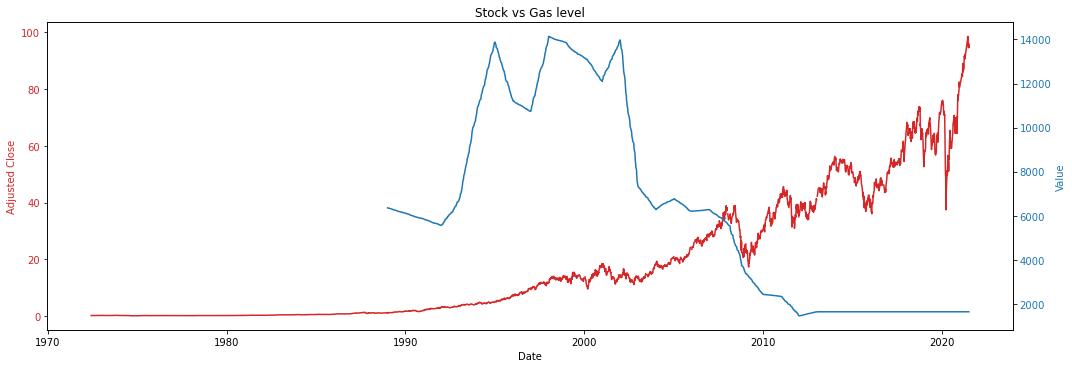

In [9]:
meta = data_merger('EMR') #EMR, AAON
plot_meta(meta)

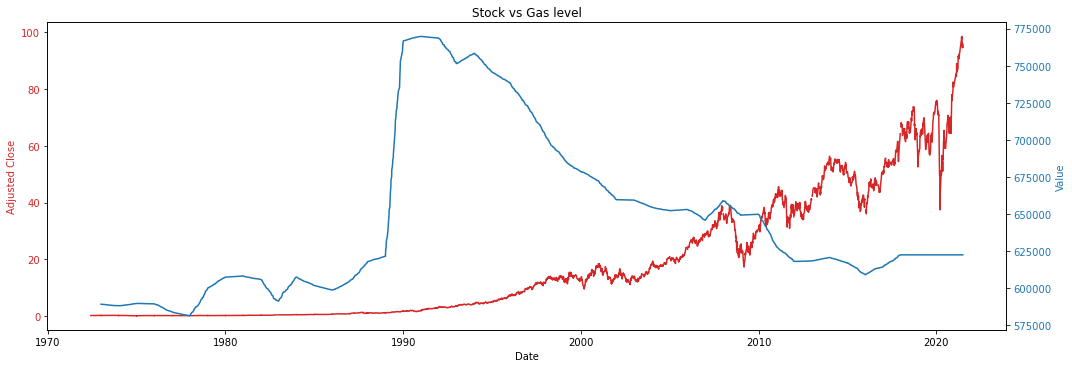

In [10]:
meta = data_merger('EMR', Indicator = 'Methane emissions') #EMR, AAON
plot_meta(meta)

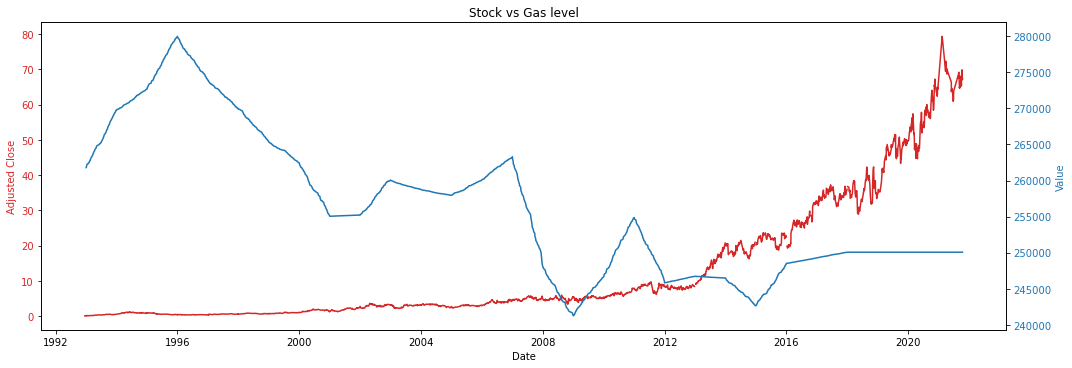

In [11]:
meta = data_merger('AAON', Indicator = 'Nitrous oxide emissions') #EMR, AAON
plot_meta(meta)

# Hypothesis: There is a correlation between Oil and gas industry and the CO2, NO2 level in America

### 1) What is Energy sector and how different industry categorized?

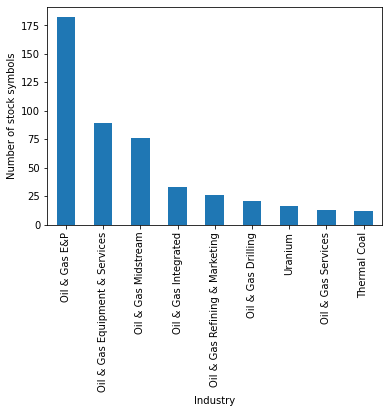

In [12]:
company_profile[company_profile.SECTOR == 'Energy']['INDUSTRY'].value_counts().plot.bar()\
.set(xlabel = 'Industry', ylabel = 'Number of stock symbols');


## 2) NO2, CO2, and CH4 level from 2001 - 2021 in the United States

Explain the peak and the trend 

In [13]:
Country = 'United States of America'
Indicator = 'Consumption of hydrochlorofluorocarbons'
gas_atlas =  data_atlas[(data_atlas.Country == Country) & (data_atlas.Year.isin(np.arange(2001, 2021)))]

CO2 = gas_atlas[data_atlas.Indicator == 'CO2 emissions']\
.sort_values(by = 'Date')[['Date', 'Value']].set_index('Date')

NO2 = gas_atlas[data_atlas.Indicator == 'Nitrous oxide emissions in energy']\
.sort_values(by = 'Date')[['Date', 'Value']].set_index('Date')

CH4 = gas_atlas[data_atlas.Indicator == 'Methane emissions in energy sector']\
.sort_values(by = 'Date')[['Date', 'Value']].set_index('Date')

<ipython-input-13-28918e1cf98f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  CO2 = gas_atlas[data_atlas.Indicator == 'CO2 emissions']\
<ipython-input-13-28918e1cf98f>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  NO2 = gas_atlas[data_atlas.Indicator == 'Nitrous oxide emissions in energy']\
<ipython-input-13-28918e1cf98f>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  CH4 = gas_atlas[data_atlas.Indicator == 'Methane emissions in energy sector']\


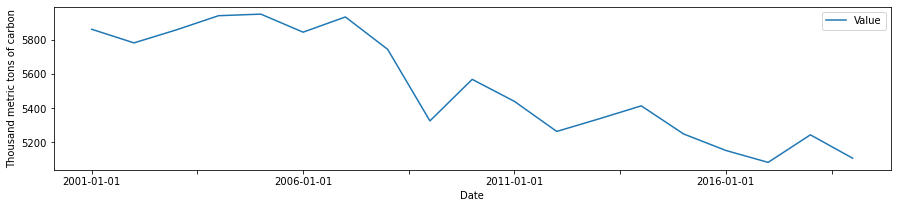

In [14]:
CO2.plot(figsize = (15,3)).set(ylabel = 'Thousand metric tons of carbon', xlabel = 'Date');

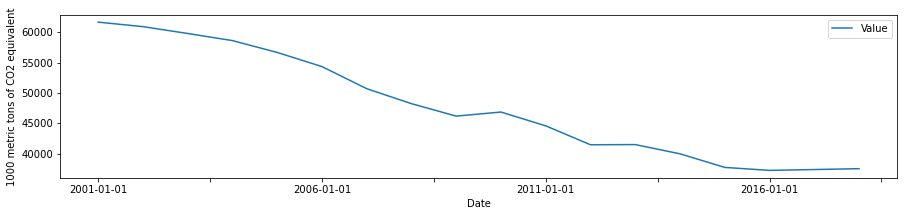

In [15]:
NO2.plot(figsize = (15,3)).set(ylabel = '1000 metric tons of CO2 equivalent', xlabel = 'Date');

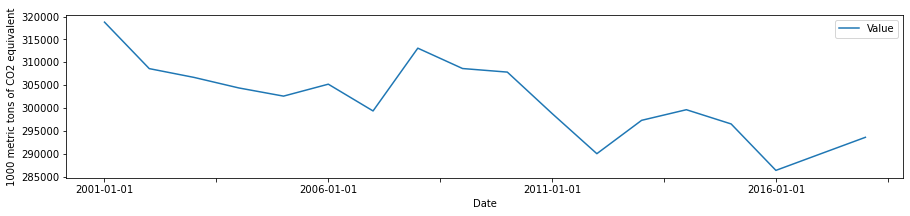

In [16]:
CH4.plot(figsize = (15,3)).set(ylabel = '1000 metric tons of CO2 equivalent', xlabel = 'Date');

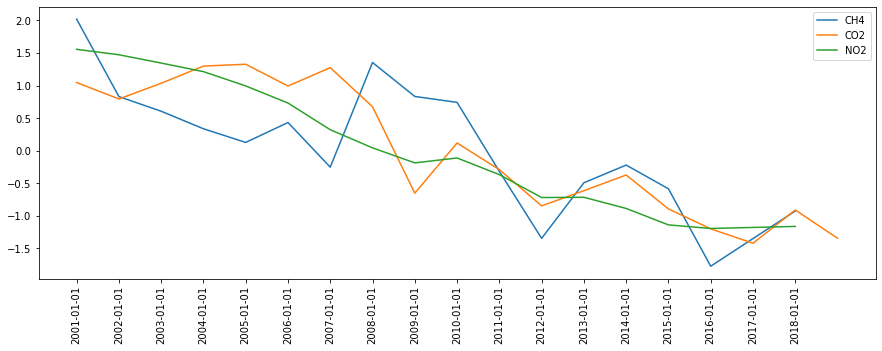

In [17]:
#Normailization all the gases
CO2_normal = (CO2-CO2.mean())/CO2.std()
NO2_normal = (NO2-NO2.mean())/NO2.std()
CH4_normal = (CH4-CH4.mean())/CH4.std()


plt.figure(figsize = (15,5))
plt.plot(CH4_normal.index, CH4_normal, label = 'CH4')
plt.plot(CO2_normal.index, CO2_normal, label = 'CO2')
plt.plot(NO2_normal.index, NO2_normal, label = 'NO2')

plt.legend()
plt.xticks(CH4_normal.index, rotation='vertical');

## 3) Stock by industry with standardization value

Explain standardization technique

Explain the peak and the trend of some plots

In [18]:
industry_symbol = company_profile[company_profile.SECTOR == 'Energy']\
.groupby('INDUSTRY').apply(lambda x: x['SYMBOL'].values)

In [28]:

def stock_by_industry_std(industry):
    industry_meta = stock_history[stock_history['SYMBOL'].isin(industry_symbol.loc[industry])]
    meta = pd.DataFrame({'DATE':pd.date_range(start = '2001-01-01', end = '2019-01-01')})
    for symbol in industry_meta.SYMBOL.unique():
        dummy = industry_meta[industry_meta.SYMBOL == symbol][['DATE', 'VOLUME', 'ADJCLOSE']]
        dummy['DATE'] = pd.to_datetime(dummy['DATE'])
        dummy.rename(columns = {'VOLUME':f'{symbol}_VOLUME', 'ADJCLOSE':f'{symbol}_ADJCLOSE'}, inplace = True)
        meta = pd.merge(left = meta, right = dummy, on = 'DATE', how = 'left')
    meta = meta.set_index('DATE')
    
    #Normalization and mean of all the symbol
    meta_normal = (meta-meta.mean())/meta.std()
    meta_normal = meta_normal.interpolate().mean(axis = 1) 
    return meta_normal

In [29]:
company_profile[company_profile.SECTOR == 'Energy']['INDUSTRY'].value_counts()

Oil & Gas E&P                     182
Oil & Gas Equipment & Services     89
Oil & Gas Midstream                76
Oil & Gas Integrated               33
Oil & Gas Refining & Marketing     26
Oil & Gas Drilling                 21
Uranium                            16
Oil & Gas Services                 13
Thermal Coal                       12
Name: INDUSTRY, dtype: int64

In [200]:
meta_normal_1

DATE
2001-01-01   -0.867865
2001-01-02   -0.368053
2001-01-03   -0.336876
2001-01-04   -0.553361
2001-01-05   -0.552401
                ...   
2018-12-28   -0.141100
2018-12-29   -0.158013
2018-12-30   -0.174927
2018-12-31   -0.191840
2019-01-01   -0.191840
Length: 6575, dtype: float64

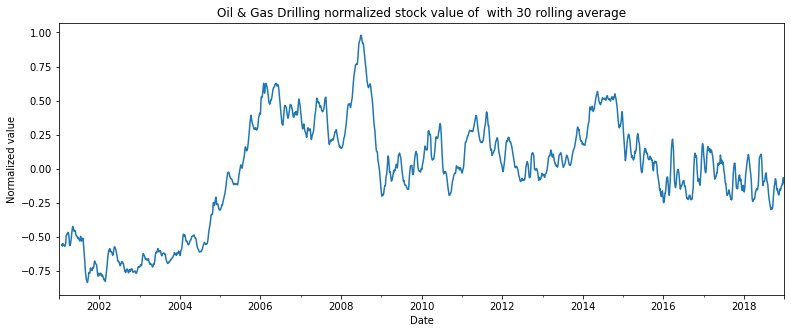

In [36]:
industry = 'Oil & Gas Drilling'
meta_normal_1 = stock_by_industry_std(industry)
meta_normal_1.rolling(window = 30).mean().plot(figsize = (13,5)).set(xlabel = 'Date', 
                                                                    ylabel = 'Normalized value',
                                                                    title = f'{industry} normalized stock value of  with 30 rolling average');

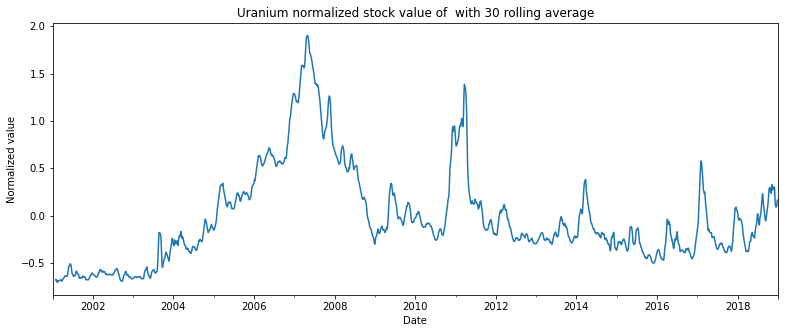

In [37]:
industry = 'Uranium'
meta_normal_2 = stock_by_industry_std(industry)
meta_normal_2.rolling(window = 30).mean().plot(figsize = (13,5)).set(xlabel = 'Date', 
                                                                    ylabel = 'Normalized value',
                                                                    title = f'{industry} normalized stock value of  with 30 rolling average');

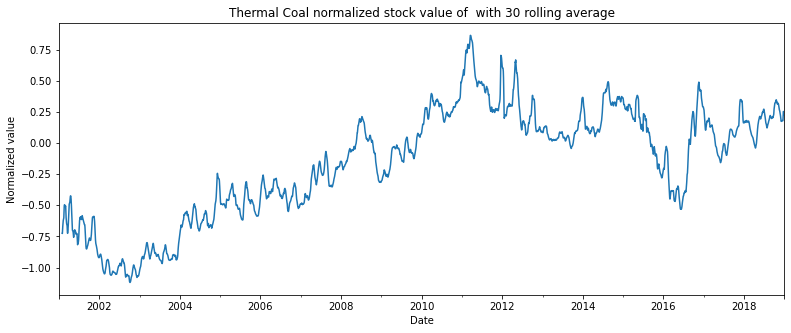

In [38]:
industry = 'Thermal Coal'
meta_normal_3 = stock_by_industry_std(industry)
meta_normal_3.rolling(window = 30).mean().plot(figsize = (13,5)).set(xlabel = 'Date', 
                                                                    ylabel = 'Normalized value',
                                                                    title = f'{industry} normalized stock value of  with 30 rolling average');

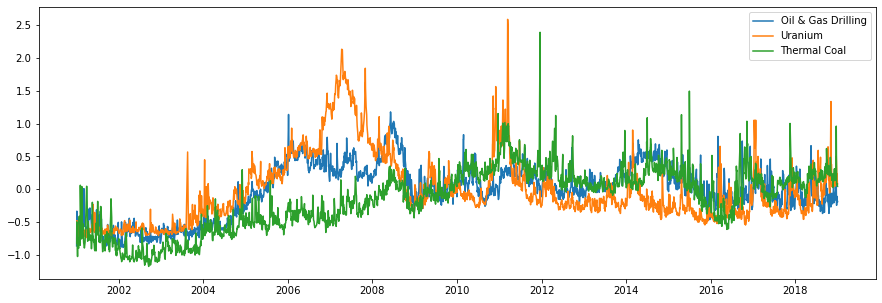

In [43]:
plt.figure(figsize = (15,5))
plt.plot(meta_normal_1.index, meta_normal_1, label = 'Oil & Gas Drilling')
plt.plot(meta_normal_2.index, meta_normal_2, label = 'Uranium')
plt.plot(meta_normal_3.index, meta_normal_3, label = 'Thermal Coal')
plt.legend()
plt.show()

## 4) Correlation between industry stock value vs Gas emission (NO2, CH4, CO2)

* Use linear regresion to detrend
* Use pearson correlation to get the score
* correlation table

In [79]:
#Interpolation, drop na()
meta_normal_1 = meta_normal_1.interpolate().dropna()
meta_normal_2 = meta_normal_2.interpolate().dropna()
meta_normal_3 = meta_normal_3.interpolate().dropna()



In [80]:
from sklearn.linear_model import LinearRegression



def detrendization(meta):
    df = meta.copy()
    df = df.interpolate().dropna()
    X = [[i] for i in range(0, len(df))]
    model = LinearRegression()
    model.fit(X, df)
    trend = model.predict(X)
    detrend = df - trend
    return detrend


detrend = detrendization(meta_normal_3)

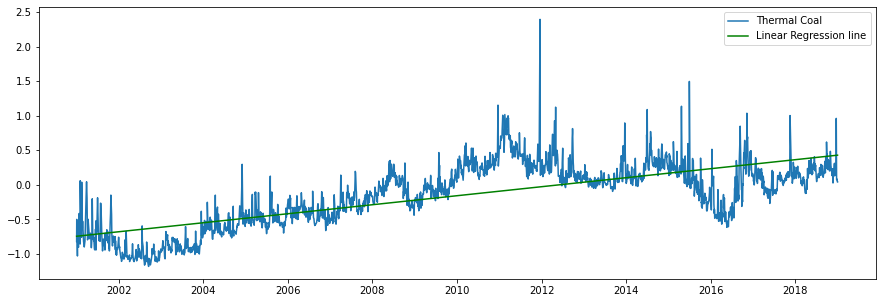

In [81]:
#Plot
plt.figure(figsize = (15,5))
plt.plot(df.index, df.values, label = 'Thermal Coal')
plt.plot(df.index, trend, label = 'Linear Regression line', c = 'g')
plt.legend()
plt.show()

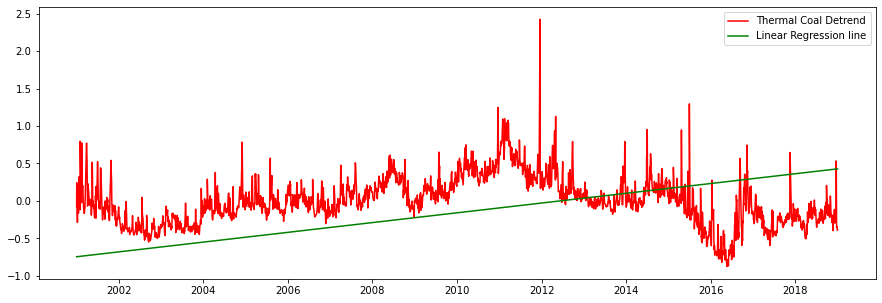

In [82]:
#Detrend
plt.figure(figsize = (15,5))

plt.plot(df.index, detrend, label = 'Thermal Coal Detrend', c = 'r')
plt.plot(df.index, trend, label = 'Linear Regression line', c= 'g')
plt.legend()
plt.show()

In [84]:
meta_detrend_1 = detrendization(meta_normal_1)
meta_detrend_2 = detrendization(meta_normal_2)
meta_detrend_3 = detrendization(meta_normal_3)

In [102]:
def to_DF(series, col_name):
    df = pd.DataFrame({})
    df['Date'] = series.index
    df[col_name] = series.values
    return df

In [1]:
def to_DF(series, col_name):
    df = pd.DataFrame({})
    df['Date'] = pd.to_datetime(series.index)
    df[col_name] = series.values
    return df

NO2_new = to_DF(NO2, 'Nitrous Oxide')
CO2_new = to_DF(CO2, 'CO2')
CH4_new = to_DF(CH4, 'CH4')

clean_1 = to_DF(meta_detrend_1, 'Oil & Gas Drilling')
clean_2 = to_DF(meta_detrend_2, 'Uranium')
clean_3 = to_DF(meta_detrend_3, 'Thermal Coal')
#Merge
meta = pd.DataFrame({'Date':pd.date_range(start = '2001-01-01', end = '2019-01-01')})
# meta.merge(clean_1, how = 'left', on = meta_detrend_1.index)

NameError: name 'NO2' is not defined

In [2]:
meta = pd.merge(left = meta, right = clean_1, how = 'left', on = 'Date')
meta = pd.merge(left = meta, right = clean_2, how = 'left', on = 'Date')
meta = pd.merge(left = meta, right = clean_3, how = 'left', on = 'Date')

meta = pd.merge(left = meta, right = NO2_new, how = 'left', on = 'Date')
meta = pd.merge(left = meta, right = CO2_new, how = 'left', on = 'Date')
meta = pd.merge(left = meta, right = CH4_new, how = 'left', on = 'Date')

NameError: name 'pd' is not defined

In [131]:
meta.dropna().corr()

,Oil & Gas Drilling,Uranium,Thermal Coal,NO2,CO2,CH4
Oil & Gas Drilling,1.000000,0.786699,0.438170,-0.019375,0.260859,0.186681
Uranium,0.786699,1.000000,0.406744,-0.032953,0.248033,0.124415
Thermal Coal,0.438170,0.406744,1.000000,-0.048576,0.009695,0.205950
NO2,-0.019375,-0.032953,-0.048576,1.000000,0.912097,0.706131
CO2,0.260859,0.248033,0.009695,0.912097,1.000000,0.690170
CH4,0.186681,0.124415,0.205950,0.706131,0.690170,1.000000


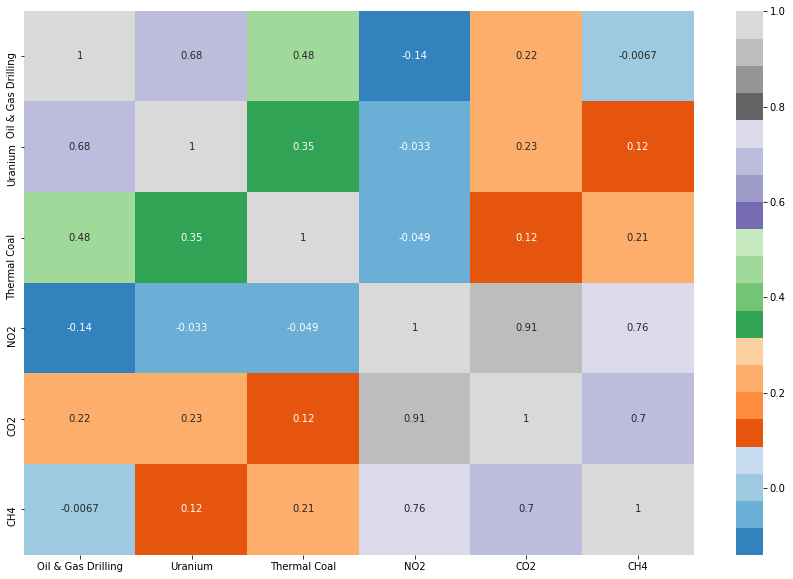

In [139]:
#Correlation matrix
plt.figure(figsize = (15,10))
sns.heatmap(meta.corr(), annot = True, cmap="tab20c")
plt.show()

# 5) Visualize industry and gas emission that has highest correlation

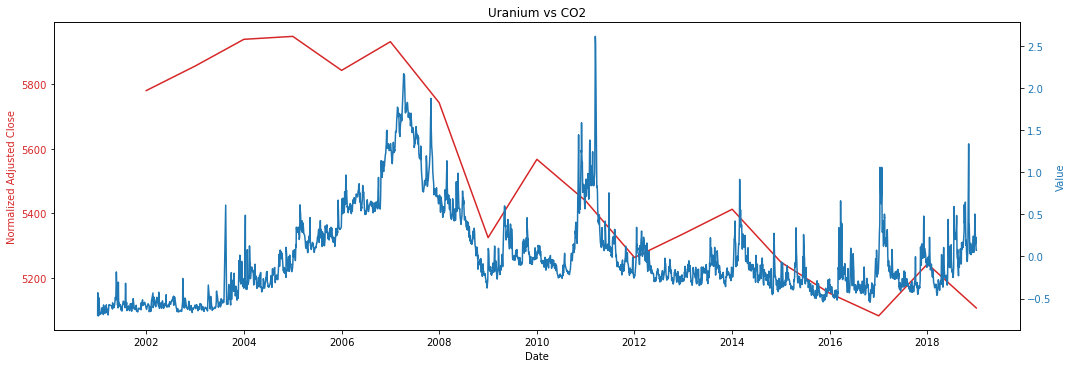

In [182]:
meta = pd.merge(
    left = clean_2,
    right = CO2_new,
    how="left",
    on = 'Date')

data1 = meta[['Date', meta.columns[-1]]].dropna() #Co2
data2 = meta[['Date', meta.columns[-2]]].dropna() #Uranium

#Plot
fig, ax1 = plt.subplots(figsize=(15,5))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Adjusted Close', color=color)
ax1.plot(data1['Date'], data1[meta.columns[-1]], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Value', color=color)  # we already handled the x-label with ax1
ax2.plot(data2['Date'], data2[meta.columns[-2]], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'{meta.columns[-2]} vs {meta.columns[-1]}')
plt.show()

# 5) Machine Learning

In [251]:
meta = pd.merge(
    left = clean_2,
    right = CO2_new,
    how="left",
    on = 'Date')
meta = pd.merge(
    left = meta,
    right = NO2_new,
    how="left",
    on = 'Date')
meta = pd.merge(
    left = meta,
    right = CH4_new,
    how="left",
    on = 'Date')
meta = meta.interpolate().dropna()
meta['Date'] = meta.index

In [252]:
def custom_train_test_split(df, target, random_state):
    X, y = df[[i for i in df.columns if i!= target]], df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=.2, 
                                                        random_state=random_state)
    print(f'Train -- Class (+): {X_train.shape} -- {y_train[y_train==1].sum()}')
    print(f'Test -- Class (+): {X_test.shape} -- {y_test[y_test==1].sum()}')
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(meta, 'Uranium', random_state = 40)

model = XGBRegressor(n_jobs = -1, verbosity = 0)
model.fit(X_train, y_train)
preds = model.predict(X_test)

mean_squared_error(preds, y_test)

<IPython.core.display.Javascript object>

Train -- Class (+): (4968, 4) -- 0.0
Test -- Class (+): (1242, 4) -- 0.0


0.00445275739329178

In [253]:
thres = -30
X, y = meta[[i for i in meta.columns if i!= 'Uranium']], meta['Uranium']
X_train, X_test, y_train, y_test = X.iloc[:thres], X.iloc[thres:], y.iloc[:thres], y.iloc[thres:]
model.fit(X_train.values, y_train.values)
preds = model.predict(X_test.values)

mean_squared_error(preds, y_test)

0.009519033250987895

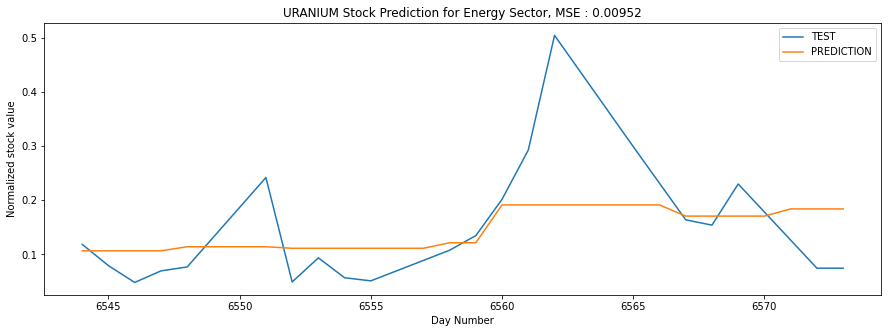

In [254]:
# plt.plot(X_train['Date'][-thres:], y_train[-thres:])
plt.figure(figsize=(15,5))
plt.plot(X_test['Date'], y_test, label = 'TEST');
plt.plot(X_test['Date'], preds, label = 'PREDICTION');
plt.title(f'URANIUM Stock Prediction for Energy Sector, MSE : {round(mean_squared_error(preds, y_test),5)}')
plt.ylabel("Normalized stock value")
plt.xlabel("Day Number")
plt.legend();

# 6) Conclusion

There are a little correlation between gas emission level and stock price

There are 3 reasons since stocks are affected by different factor

We need more data to investigate